In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import os
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


def get_a1(gamma_A, gamma_B):
    return gamma_A + gamma_B

def get_a2(gamma_A, gamma_B, nu_AA, nu_BB):
    return gamma_A * gamma_B + nu_AA + nu_BB

def get_a3(gamma_A, gamma_B, nu_AA, nu_BB):
    return gamma_A * nu_BB + gamma_B * nu_AA

def get_a4(nu_AA, nu_BB, nu_AB_BA):
    return nu_AA * nu_BB - nu_AB_BA

def get_Delta2(gamma_A, gamma_B, nu_AA, nu_BB):
    a1 = get_a1(gamma_A, gamma_B)
    a2 = get_a2(gamma_A, gamma_B, nu_AA, nu_BB)
    a3 = get_a3(gamma_A, gamma_B, nu_AA, nu_BB)
    return a1 * a2 - a3

def get_Delta3(gamma_A, gamma_B, nu_AA, nu_BB, nu_AB_BA):
    a1 = get_a1(gamma_A, gamma_B)
    a2 = get_a2(gamma_A, gamma_B, nu_AA, nu_BB)
    a3 = get_a3(gamma_A, gamma_B, nu_AA, nu_BB)
    a4 = get_a4(nu_AA, nu_BB, nu_AB_BA)
    Delta2 = a1 * a2 - a3
    return a3 * Delta2 - a1**2 * a4

In [3]:
def get_gamma_nu(sigma_D, sigma_v, Pe, w1, w2, wc, q, ll=3./20, simple_gamma=False):
    if simple_gamma:
        gamma_A = sigma_D / q
        gamma_B = 1 / q
    else:
        gamma_A = sigma_D / q + (Pe * sigma_v) ** 2 / (16 * sigma_D) * q
        gamma_B = 1 / q + Pe ** 2 / 16 * q
    nu_AA = 0.5 * (Pe * sigma_v)**2 * (1 + (w1-1) * (1-ll*q**2))
    nu_BB = 0.5 * Pe**2 * (1 + (w2-1) * (1-ll*q**2))
    nu_AB_BA = 0.25 * Pe**4 * sigma_v**2 * wc * (1-ll*q**2)**2
    return gamma_A, gamma_B, nu_AA, nu_BB, nu_AB_BA

def get_gamma(sigma_D, sigma_v, Pe, q, simple_gamma=False):
    if simple_gamma:
        gamma_A = sigma_D / q
        gamma_B = 1 / q
    else:
        gamma_A = sigma_D / q + (Pe * sigma_v) ** 2 / (16 * sigma_D) * q
        gamma_B = 1 / q + Pe ** 2 / 16 * q
    return gamma_A, gamma_B

def get_nu(sigma_v, Pe, w1, w2, wc, q, ll=3./20):
    nu_AA = 0.5 * (Pe * sigma_v)**2 * (1 + (w1-1)*(1-ll*q**2))
    nu_BB = 0.5 * Pe**2 * (1 + (w2-1)*(1-ll*q**2))
    nu_AB_BA = 0.25 * Pe**4 * sigma_v**2 * wc * (1-ll*q**2)**2
    return nu_AA, nu_BB, nu_AB_BA



In [4]:
def find_long_instabi(sigma_D, sigma_v, Pe, w1, w2, wc, q0=1e-4, ll=3./20, simple_gamma=False):
    gamma_A, gamma_B, nu_AA, nu_BB, nu_AB_BA = get_gamma_nu(sigma_D, sigma_v, Pe, w1, w2, wc, q0, ll=ll, simple_gamma=simple_gamma)
    # a3 = get_a3(gamma_A, gamma_B, nu_AA, nu_BB)
    a4 = get_a4(nu_AA, nu_BB, nu_AB_BA)
    Delta_2 = get_Delta2(gamma_A, gamma_B, nu_AA, nu_BB)
    Delta_3 = get_Delta3(gamma_A, gamma_B, nu_AA, nu_BB, nu_AB_BA)
    # long-wave instabilities
    mask_LI = np.logical_or(a4 <= 0, np.logical_or(Delta_2 <= 0, Delta_3 <= 0))
    # long-wave stabilities
    mask_LS = np.logical_and(a4 > 0, np.logical_and(Delta_2 > 0, Delta_3 > 0))
    sigma_0 = sigma_D / sigma_v ** 2
    mask_LOI = np.logical_and(mask_LI, (w1-sigma_0 * w2)**2 < 4*(-sigma_0 * wc))
    mask_LSI = np.logical_and(mask_LI, (w1-sigma_0 * w2)**2 >= 4*(-sigma_0 * wc))
    return mask_LS, mask_LOI, mask_LSI

def find_first_zero(f_arr, q_arr):
    for i, q in enumerate(q_arr):
        if f_arr[i] < 0:
            return q
    return 0

def find_first_zeros(a4, Delta3, q_arr):
    q0_a4, q0_Delta3 = 0, 0
    for i, q in enumerate(q_arr):
        if a4[i] < 0 and Delta3[i] > 0:
            q0_a4 = q
            break
        elif a4[i] > 0 and Delta3[i] < 0:
            q0_Delta3 = q
            break
        elif a4[i] < 0 and Delta3[i] < 0:
            q0_a4 = q
            q0_Delta3 = q
            break
    return q0_a4, q0_Delta3


def find_short_instabi(sigma_D, sigma_v, Pe, w1, w2, wc, qmin=1e-4, qmax=np.sqrt(20/3), Nq=100, ll=3./20, simple_gamma=False):
    q_arr = np.linspace(qmin, qmax, Nq, endpoint=False)
    gamma_A_q, gamma_B_q, nu_AA_q, nu_BB_q, nu_AB_BA_q = get_gamma_nu(
        sigma_D, sigma_v, Pe, w1, w2, wc, q_arr, ll=ll, simple_gamma=simple_gamma)
    a4_q = get_a4(nu_AA_q, nu_BB_q, nu_AB_BA_q)
    Delta3_q = get_Delta3(gamma_A_q, gamma_B_q, nu_AA_q, nu_BB_q, nu_AB_BA_q)
    q0_a4, q0_D3 = 0., 0.
    if np.min(a4_q) < 0 or np.min(Delta3_q) < 0:
        q0_a4, q0_D3 = find_first_zeros(a4_q, Delta3_q, q_arr)
    return q0_a4, q0_D3

def find_contours(state):
    contours = {}
    contours["LWS"] = measure.find_contours(state==1)
    contours["LWO"] = measure.find_contours(state==2)
    contours["SWS"] = measure.find_contours(state==3)
    contours["SWO"] = measure.find_contours(state==4)
    return contours

In [5]:
def get_PD_w1_w2_data(sigma_D, sigma_v, Pe, wc, extent=[-8, 8, -8, 8],
                      qmin=1e-5, qmax=1, Nq=200, resolution=1000, overwrite=False):
    fout = "data/PD_w1_w2/sD%g_sv%g_Pe%g_wc%g_qm%g_r%g.npz" % (
            sigma_D, sigma_v, Pe, wc, qmax, resolution
        )
    if not overwrite and os.path.exists(fout):
        with np.load(fout, "rb") as data:
            return data["extent"], data["state"], data["q_range"]
    else:
        nrows, ncols = resolution, resolution
        w1, w2 = np.meshgrid(
            np.linspace(extent[0], extent[1], ncols),
            np.linspace(extent[2], extent[3], nrows)
        )
        mask_LS, mask_LOI, mask_LSI = find_long_instabi(sigma_D, sigma_v, Pe, w1, w2, wc)
        q0_a4, q0_Delta3 = np.zeros((2, nrows, ncols))
        for row in range(nrows):
                for col in range(ncols):
                    if mask_LS[row, col]:
                        q0_a4[row, col], q0_Delta3[row, col] = find_short_instabi(
                            sigma_D, sigma_v, Pe, w1[row, col], w2[row, col], wc)
        state = np.zeros((nrows, ncols), np.byte)
        state[mask_LSI] = 1
        state[mask_LOI] = 2
        state[q0_a4 > 0] = 3
        state[q0_Delta3 > 0] = 4
        q_range = np.array([qmin, qmax, Nq])
        np.savez_compressed(fout, extent=extent, state=state, q_range=q_range)
        return extent, state, q_range


def plot_PD_w1_w2(state, extent, xlim=None, ylim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True, constrained_layout=True)
        flag_show = True
    else:
        flag_show = False

    nrows, ncols = state.shape
    # ax.imshow(state, origin="lower", extent=extent)
    contours = find_contours(state)

    for contour in contours["SWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        ax.fill(x, y, c="tab:green", alpha=0.5)
    
    for contour in contours["SWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        ax.fill(x, y, c="tab:orange", alpha=0.5)

    for contour in contours["LWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        # ax.fill(x, y, c="tab:blue", alpha=0.5)
        if (contour[:, 0].max() == nrows-1):
            ax.fill_betweenx(y, extent[0], x, color="tab:blue", alpha=0.5)
        elif (contour[:, 1].max() == ncols - 1):
            ax.fill_between(x, extent[2], y, color="tab:blue", alpha=0.5)

    for contour in contours["LWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        ax.fill(x, y, c="tab:pink", alpha=0.5)
    if xlim is None:
        xlim = [extent[0], extent[1]]
    if ylim is None:
        ylim = [extent[2], extent[3]]
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])

    if flag_show:
        plt.show()
        plt.close()

# sigma_D = 1
# sigma_v = 4
# Pe = 1
# wc = -4
# extent, state, q_range = get_PD_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2, Nq=500, resolution=1000)
# plot_PD_w1_w2(state, extent)

# extent, state, q_range = get_PD_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2, Nq=500, resolution=4000)
# plot_PD_w1_w2(state, extent)

In [6]:
def get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, extent=[-8, 8, -8, 8],
                            qmin=1e-5, qmax=2.5, Nq=400, resolution=1000, overwrite=False):
    fout = "data/PD_tilde_w1_w2/sD%g_sv%g_Pe%g_wc%g_qm%g_r%g.npz" % (
            sigma_D, sigma_v, Pe, wc, qmax, resolution
        )
    if not overwrite and os.path.exists(fout):
        with np.load(fout, "rb") as data:
            return data["extent"], data["state"], data["q_range"]
    else:
        nrows, ncols = resolution, resolution
        tilde_w1, tilde_w2 = np.meshgrid(
            np.linspace(extent[0], extent[1], ncols),
            np.linspace(extent[2], extent[3], nrows)
        )
        sigma = sigma_D / sigma_v**2
        w1 = np.sqrt( sigma * np.abs(wc)) * tilde_w1
        w2 = np.sqrt(np.abs(wc) / sigma) * tilde_w2 
        mask_LS, mask_LOI, mask_LSI = find_long_instabi(sigma_D, sigma_v, Pe, w1, w2, wc)
        q0_a4, q0_Delta3 = np.zeros((2, nrows, ncols))
        for row in range(nrows):
                for col in range(ncols):
                    if mask_LS[row, col]:
                        q0_a4[row, col], q0_Delta3[row, col] = find_short_instabi(
                            sigma_D, sigma_v, Pe, w1[row, col], w2[row, col], wc)
        state = np.zeros((nrows, ncols), np.byte)
        state[mask_LSI] = 1
        state[mask_LOI] = 2
        state[q0_a4 > 0] = 3
        state[q0_Delta3 > 0] = 4
        q_range = np.array([qmin, qmax, Nq])
        np.savez_compressed(fout, extent=extent, state=state, q_range=q_range)
        return extent, state, q_range


def plot_PD_tilde_w1_w2(state, extent, xlim=None, ylim=None, ax=None, only_SWO=False, legend_loc="upper left", legend_font_size="medium"):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=True, sharey=True, constrained_layout=True)
        flag_show = True
    else:
        flag_show = False

    nrows, ncols = state.shape
    # ax.imshow(state, origin="lower", extent=extent)
    contours = find_contours(state)

    fill_list = []
    if not only_SWO:
        fill1 = None
        for contour in contours["SWS"]:
            x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
            y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
            fill1, = ax.fill(x, y, c="tab:orange", alpha=0.5, label="short-wave stationary")
        if fill1 is not None:
            fill_list.append(fill1)

        for contour in contours["LWS"]:
            x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
            y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
            # ax.fill(x, y, c="tab:blue", alpha=0.5)
            if (contour[:, 0].max() == nrows-1):
                fill2 = ax.fill_betweenx(y, extent[0], x, color="tab:blue", alpha=0.5, label="long-wave\nstationary")
            elif (contour[:, 1].max() == ncols - 1):
                fill2 = ax.fill_between(x, extent[2], y, color="tab:blue", alpha=0.5, label="long-wave\nstationary")
        fill_list.append(fill2)

        for contour in contours["LWO"]:
            x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
            y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]

            x_new = np.zeros(x.size + 1)
            y_new = np.zeros(y.size + 1)
            x_new[:x.size] = x
            y_new[:y.size] = y
            x_new[-1] = extent[0]
            y_new[-1] = extent[2]
            fill3, = ax.fill(x_new, y_new, c="tab:pink", alpha=0.5, label="long-wave\noscillatory")
        fill_list.append(fill3)
    x_SWO, y_SWO = None, None
    for contour in contours["SWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        fill4, = ax.fill(x, y, c="tab:green", alpha=0.25, label="short-wave\noscillatory")
        if x_SWO is None:
            x_SWO, y_SWO = x, y
        elif x_SWO.size < x.size:
            x_SWO, y_SWO = x, y
    fill_list.append(fill4)
    
    if xlim is None:
        xlim = [extent[0], extent[1]]
    if ylim is None:
        ylim = [extent[2], extent[3]]
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    # if not only_SWO:
    #     fill_legend = ax.legend(handles=fill_list, loc=legend_loc, fontsize=legend_font_size, borderpad=0.3, labelspacing=0.3)
    #     ax.add_artist(fill_legend)

    if flag_show:
        plt.show()
        plt.close()
    return x_SWO, y_SWO


# Pe = 1
# wc = -1
# extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
# plot_PD_tilde_w1_w2(state, extent)


# Pe = 0.1
# wc = -1
# extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
# plot_PD_tilde_w1_w2(state, extent)


# Pe = 100
# wc = -1
# extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
# plot_PD_tilde_w1_w2(state, extent)

# xlim = [-4, 4]
# ylim = [-4, 4]

# Pe = 10
# wc = -1
# extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
# x, y = plot_PD_tilde_w1_w2(state, extent, xlim, ylim)



In [7]:
def get_PD_wc_Pe_data(sigma_D, sigma_v, w1, w2, extent=[-10, 0, 0, 11],
                      qmin=1e-5, qmax=1, Nq=200, resolution=1000, overwrite=False, ll=np.sqrt(3./20)):
    fout = "data/PD_wc_Pe/sD%g_sv%g_w1%g_w2%g_qm%g_r%g.npz" % (
            sigma_D, sigma_v, w1, w2, qmax, resolution
        )
    if not overwrite and os.path.exists(fout):
        with np.load(fout, "rb") as data:
            return data["extent"], data["state"], data["q_range"]
    else:
        nrows, ncols = resolution, resolution
        wc, Pe = np.meshgrid(
            np.linspace(extent[0], extent[1], ncols),
            np.linspace(extent[2], extent[3], nrows)
        )
        # wc_1D = np.logspace(-2, 2, ncols)
        # Pe_1D = np.logspace(-2, 2, nrows)
        # wc, Pe = np.meshgrid(
        #     -wc_1D[::-1],
        #     Pe_1D
        # )
        mask_LS, mask_LOI, mask_LSI = find_long_instabi(sigma_D, sigma_v, Pe, w1, w2, wc)
        q0_a4, q0_Delta3 = np.zeros((2, nrows, ncols))
        for row in range(nrows):
                for col in range(ncols):
                    if mask_LS[row, col]:
                        q0_a4[row, col], q0_Delta3[row, col] = find_short_instabi(
                            sigma_D, sigma_v, Pe[row, col], w1, w2, wc[row, col], qmin=qmin, qmax=qmax, ll=ll)
        state = np.zeros((nrows, ncols), np.byte)
        state[mask_LSI] = 1
        state[mask_LOI] = 2
        state[q0_a4 > 0] = 3
        state[q0_Delta3 > 0] = 4
        q_range = np.array([qmin, qmax, Nq])
        np.savez_compressed(fout, extent=extent, state=state, q_range=q_range)
        return extent, state, q_range


def plot_PD_wc_Pe(state, extent, xlim=None, ylim=None, ax=None, alpha=0.25):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=True, sharey=True, constrained_layout=True)
        flag_show = True
    else:
        flag_show = False
    nrows, ncols = state.shape
    contours = find_contours(state)
    for contour in contours["SWO"]:
        print(contour)
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        ax.fill_between(x, y, y.max(), color="tab:green", alpha=alpha)
    # ax.imshow(state, origin="lower", extent=extent)
    # ax.plot(x, y, ".")
    # ax.set_xscale("log")
    # ax.set_yscale("log")
    if xlim is None:
            xlim = [extent[0], extent[1]]
    if ylim is None:
        ylim = [extent[2], extent[3]]
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])

    # if flag_show:
    #     plt.show()
    #     plt.close()
    
    # plt.loglog(-x, y)
    # # plt.plot(x, y)
    # plt.show()
    # plt.close()
    

# extent, state, q_range = get_PD_wc_Pe_data(1, 1, 1, 1, overwrite=False)
# plot_PD_wc_Pe(state, extent)

    

In [8]:
def PD_Pe_vs_chi(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True)
        flag_show = True
    else:
        flag_show = False

    extent, state, q_range = get_PD_wc_Pe_data(1, 1, 1, 1, overwrite=False, resolution=2000, qmax=1, ll=0)
    plot_PD_wc_Pe(state, extent, ax=ax, xlim=[-4.1, 0], ylim=[0, 10.5])
    with np.load("data/PD_wc_Pe/Dr_etaAB.npz", "r") as data:
        Dr, eta_AB, state, vel_var = data["Dr"], data["eta_AB"], data["state"], data["vel_var"]

        vmin, vmax = vel_var.min(), vel_var.max()
        print("val:", vmin, vmax)
        mask_D = state == 1
        mask_H = state == 0
        chi = -eta_AB**2
        Pe = 1 / Dr
        # ax.plot(chi[mask_D], Pe[mask_D], "^")
        # ax.plot(chi[mask_H], Pe[mask_H], "o")
        sca1 = ax.scatter(chi[mask_D], Pe[mask_D], s=30, c=vel_var[mask_D], marker="^", vmin=vmin, vmax=0.1, label="travelling bands", cmap="cividis")
        sca2 = ax.scatter(chi[mask_H], Pe[mask_H], s=30, c=vel_var[mask_H], marker="x", vmin=vmin, vmax=0.1, label="homogenous phase", cmap="cividis")

    # ll = 3/20
    # chi = np.linspace(-4.1, -0.1)
    # Pe = np.sqrt(-ll/chi)
    # ax.plot(chi, Pe, "--", c="tab:red", label=r"$-\chi \mathrm{Pe}=\ell^2$")
    # reduced_line = onset_instability_reduced_model(ax, q_max=1, ll=0)
    cax = ax.inset_axes([0.15, 0.38, 0.6, 0.05])
    cb = plt.colorbar(sca1, extend="max", orientation="horizontal", cax=cax)
    # ax.set_xlabel(r"$\chi$", fontsize="x-large")
    # ax.set_ylabel(r"${\rm Pe}$", fontsize="x-large")
    # cb.set_label(r"${\rm Var}(v)\equiv \langle \left[ \langle v_i^2(t)\rangle_i - \langle v_i(t)\rangle_i^2 \right]\rangle_t$", fontsize="x-large")
    cb.set_label(r"${\rm Var}(v)$", fontsize="x-large")

    # ax.set_title(r"$\chi_A=\chi_B=1, \sigma=\sigma_v=\sigma_D=1$", fontsize="x-large")

    patches = [
            sca1, sca2,
            mpatches.Patch(color='tab:green', label='SOI', alpha=0.2),
            # reduced_line
            ]
    legend1 = ax.legend(handles=patches, loc=(0.1, 0.5), fontsize="x-large", borderpad=0.2)
    if flag_show:
        plt.show()
        # plt.savefig("fig/S1.pdf")
        plt.close()

In [9]:
import matplotlib.patches as mpatches
from matplotlib import image as mpimg
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

fig = plt.figure(constrained_layout=True, figsize=(8, 6))
subfigs = fig.subfigures(2, 1, wspace=0.001, hspace=0.002, height_ratios=[3, 1.6])
(ax1, ax2) = subfigs[0].subplots(1, 2)

# (ax3, ax4) = subfigs[1].subplots(1, 2, width_ratios=[1, 3])
(subfig3, subfig4) = subfigs[1].subfigures(1, 2, wspace=0.01, width_ratios=[1, 3.1])
# ax3 = subfig3.add_subplot(1, 2, 1)
ax3 = subfig3.subplots()
ax4 = subfig4.subplots()
xlim = [-1.5, 4]
ylim = [-1.5, 4]

label_font_size = "x-large"
# plot_PD_rho_eq_w1_w2(ax1, xmin=xlim[0], xmax=xlim[1], ymin=ylim[0], ymax=ylim[1], loc_line_legend=(0.35, 0.43), loc_fill_legend=(0.41, 0.2), legend_font_size="medium")

xlabel = r"$\chi_A/\sqrt{\sigma|\chi|}$"
ylabel = r"$\sqrt{\sigma / |\chi|}\chi_B$"
# ax1.set_xlabel(xlabel, fontsize=label_font_size)
# ax1.set_ylabel(ylabel, fontsize=label_font_size)

Pe = 1
sigma_D=1
sigma_v = 1
wc = -1
extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
x, y = plot_PD_tilde_w1_w2(state, extent, xlim, ylim, ax=ax1, legend_loc=(0.28, 0.68), legend_font_size="medium")
# mask = x + y > 0.0001
# x = x[mask]
# y = y[mask]
cm = plt.cm.get_cmap('tab20c')
line, = ax1.plot(x, y, "-", c=cm.colors[12], label="%g" % Pe)
line_list = [line]
for i, Pe in enumerate([2, 4, 8]):
    extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
    x, y = plot_PD_tilde_w1_w2(state, extent, xlim, ylim, ax=ax1, only_SWO=True)
    line, = ax1.plot(x, y, c=cm.colors[i+13], label="%g" % Pe)
    line_list.append(line)
# ax2.set_xlabel(xlabel, fontsize=label_font_size)

PD_Pe_vs_chi(ax2)

# ax2.legend()
ax1.axhline(0, linestyle=":", color="tab:grey")
ax1.axvline(0, linestyle=":", color="tab:grey")
line_legend = ax1.legend(handles=line_list, title="$\sigma_v=\sigma_D=1,$\n$\\chi=-1,{\\rm Pe}=$", loc=(0.7, 0.25), fontsize="medium", borderpad=0.3)
ax1.add_artist(line_legend)

# ax2_in = ax2.inset_axes([0.13, 0.08, 0.32, 0.32])
# ax2_in = ax2.inset_axes([0.685, 0.63, 0.3, 0.3])

# extent, state, q_range = get_PD_wc_Pe_data(1, 1, 1, 1, overwrite=False)
# plot_PD_wc_Pe(state, extent, ax=ax2_in, xlim=[-4, 0], ylim=[0, 11])
# ax2_in.set_xticks([-4, -2, 0])
# ax2_in.set_yticks([0, 5, 10])
# ax2_in.set_title(r"$\chi_{A,B}=1$")
# ax2_in.text(0.85, 0.08, r"$\chi$", transform=ax2_in.transAxes, fontsize="large")
# ax2_in.text(0.05, 0.75, r"${\rm Pe}$", transform=ax2_in.transAxes, rotation='vertical', fontsize="large")
# ax2_in.plot(-0.8**2, 10, "o", ms=1)
# ax2_in.plot(-0.8**2, 1, "o", ms=1)
# ax2_in.plot(-0.5**2, 10, "o", ms=1)
ax2.scatter(-1, 10, s=60, c="tab:green", marker="^", edgecolors="k", zorder=2.5)
# with open("data/PD_wc_Pe/Dr_etaAB.txt", "r") as f:
#     lines = f.readlines()
#     for line in lines:
#         s = line.rstrip("\n").split(";")
#         Dr, eta_AB, state = float(s[0]), float(s[1]), int(s[2])
#         if state == 1:
#             ax2_in.plot(-eta_AB**2, 1/Dr, "^", c="tab:green", ms=3, fillstyle="none")
#         else:
#             ax2_in.plot(-eta_AB**2, 1/Dr, "x", c="tab:grey", ms=3)

### ax3E
from NRQS_Turing import DMatrix_w_surface_tension
# ax3.set_xlabel(r"$q$", fontsize=label_font_size, labelpad=0.5)
# ax3.set_ylabel(r"$\Re(\lambda)$", fontsize=label_font_size)

# q_arr = np.linspace(1e-6, np.sqrt(20/3), 1000)
q_arr = np.logspace(-4, np.log10(np.sqrt(20/3)), 1000, endpoint=False)

M1 = DMatrix_w_surface_tension(1, -3.125, 0.32, -2.2, phiA=1, phiB=1, Dr_A=6, Dr_B=6, bar_vA=3, bar_vB=1)
M2 = DMatrix_w_surface_tension(-0.2, -3.125, 0.32, -2.21, phiA=1, phiB=1, Dr_A=6, Dr_B=6, bar_vA=3, bar_vB=1)
# M2 = DMatrix_w_surface_tension(-0.21, -3.125, 0.32, -2.25, phiA=1, phiB=1, Dr_A=6, Dr_B=6, bar_vA=3, bar_vB=1)

M3 = DMatrix_w_surface_tension(-1.1, 0.08, -0.125, -1.1, phiA=1, phiB=1, Dr_A=0.1, Dr_B=0.1, bar_vA=1, bar_vB=1)
M4 = DMatrix_w_surface_tension(0, 0.8, -0.8, 0, phiA=1, phiB=1, Dr_A=0.1, Dr_B=0.1, bar_vA=1, bar_vB=1)
c_list = ["tab:blue", "tab:pink", "tab:green"]
M_list = [M1, M3, M4]
scale_factor = np.array([0.06, 0.1, 0.1]) * 100
for i, M in enumerate(M_list):
    lamb = M.get_lambda_q(q_arr).max(axis=1)
    mask_r = np.abs(lamb.imag) <= 1e-8
    mask_i = mask_r == False

    line, = ax3.plot(q_arr[mask_r], lamb[mask_r].real * scale_factor[i], c=c_list[i])
    ax3.plot(q_arr[mask_i], lamb[mask_i].real * scale_factor[i], c=line.get_c(), linestyle="dashed")
    # line, = plt.plot(q_arr, np.abs(lamb.imag) * Dr[i], c=c_list[i])

line1 = ax3.axhline(-100, linestyle="-", c="k", label=r"$\Im(\lambda)=0$")
line2 = ax3.axhline(-100, linestyle="--", c="k", label=r"$\Im(\lambda)\neq 0$")
legend1 = ax3.legend(handles=[line1, line2], fontsize="large", loc=(0.2, 0.69), frameon=False, labelspacing=0.08, handletextpad=0.3)
ax3.add_artist(legend1)
patches = [mpatches.Patch(color='tab:blue', label='Long-wave Stationary\nInstability (LSI)', alpha=0.5),
           mpatches.Patch(color='tab:pink', label='Long-wave Oscillatory\nInstability (LOI)',alpha=0.5),
        #    mpatches.Patch(color='tab:orange', label='Short-wave\nStationary\nInstability (SSI)', alpha=0.5),
           mpatches.Patch(color='tab:green', label='Short-wave Oscillatory\nInstability (SOI)', alpha=0.5),
        ]
legend2 = ax1.legend(handles=patches, loc=(0.31, 0.64), fontsize="large", frameon=False, labelspacing=0.25)


ax3.set_xscale("log")
ax3.set_xlim(1e-2, 2.1)
ax3.set_ylim(-0.25, 0.55)
ax3.axhline(0, linestyle=":", c="k")
ax3.set_yticks([-0.2, 0, 0.2, 0.4])
### ax4
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/snap_1_3_w_theta_r.png")
ax4.imshow(im)
ax4.set_yticks([])
ax4.set_xticks([])


ax4_cb = ax4.inset_axes([0.23, 0.01, 0.1, 0.3])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/circle2.png")
ax4_cb.set_title(r"$\theta_i$", fontsize="x-large")
ax4_cb.imshow(im)
ax4_cb.set_xticks([])
ax4_cb.set_yticks([])

ax4_in0 = ax4.inset_axes([0.29, 0.87, 0.04, 0.12])
ax4_in0.set_xticks([])
ax4_in0.set_yticks([])
ax4_in0.scatter(0.4, 0.5, s=60, c="tab:blue", marker="o", edgecolors="k")
ax1.scatter(3, -1, s=60, c="tab:blue", marker="o", edgecolors="k")


# ax4_in0 = ax4.inset_axes([0.92, 0.92, 0.08, 0.08])
# ax4_in0.set_xticks([])
# ax4_in0.set_yticks([])
# ax4_in0.scatter(0.4, 0.5, s=60, c="tab:orange", marker="p", edgecolors="k")
# ax1.scatter(1.245, -0.18, s=60, c="tab:orange", marker="p", edgecolors="k", zorder=2.5)


ax4_in0 = ax4.inset_axes([0.62, 0.87, 0.04, 0.12])
ax4_in0.set_xticks([])
ax4_in0.set_yticks([])
ax4_in0.scatter(0.4, 0.5, s=60, c="tab:pink", marker="s", edgecolors="k")
ax1.scatter(-1, -1, s=60, c="tab:pink", marker="s", edgecolors="k")

ax4_in0 = ax4.inset_axes([0.955, 0.87, 0.04, 0.12])
ax4_in0.set_xticks([])
ax4_in0.set_yticks([])
ax4_in0.scatter(0.4, 0.5, s=60, c="tab:green", marker="^", edgecolors="k")
ax1.scatter(1, 1, s=60, c="tab:green", marker="^", edgecolors="k", zorder=2.5)

# ax4.arrow(0.25, 0.25, -0.1, 0, transform=ax4.transAxes, width=0.01)
import matplotlib.lines as mlines
blue_circle = mlines.Line2D([], [], color="blue", marker="o", markersize=2, label="A", lw=0)
red_circle = mlines.Line2D([], [], color="red", marker="o", markersize=2, label="B", lw=0)
ax4.legend(handles=[blue_circle, red_circle], loc=(0.35, 0.7), fontsize="large")

ax4.arrow(0.5, 0.5, -0.05, 0, transform=ax4.transAxes, width=0.03, color="tab:pink", ec="k", head_length=0.03)
# ax4.arrow(0.78, 0.28, 0.05, 0, transform=ax4.transAxes, width=0.008)
# ax4.arrow(0.79, 0.28, 0.05, 0, transform=ax4.transAxes, width=0.008)
ax4.arrow(0.80, 0.5, 0.05, 0, transform=ax4.transAxes, width=0.02, color="tab:green", ec="k", head_length=0.03)
ax4.arrow(0.80, 0.5, 0.05 * np.cos(-np.pi * 2 / 3), 0.05 * np.sin(-np.pi * 2 / 3) * 3, transform=ax4.transAxes, width=0.01, color="tab:green", ec="k", head_length=0.03)
ax4.arrow(0.80, 0.5, 0.05 * np.cos(np.pi * 2 / 3), 0.05 * np.sin(np.pi * 2 / 3) * 3, transform=ax4.transAxes, width=0.01, color="tab:green", ec="k", head_length=0.03)

ax1.set_title(r"$\chi<0, \sigma=\sigma_D/\sigma_v^2$", fontsize="large")
ax2.set_title("$\chi_A=\chi_B=1, \sigma_D=\sigma_v=1$", fontsize="large")
# ax3.set_title("(c)", fontsize="large")
# ax4.set_title("(d)", fontsize="large")

# ax3.text(-0.4, 0.48, r"$\Re (\lambda)$", rotation='vertical', fontsize=label_font_size)

# subfig4.text(0.7, 0.99, xlabel, fontsize=label_font_size)
# subfig4.text(0.03, 0.99, xlabel, fontsize=label_font_size)
# subfig3.text(0.7, 0.02, r"$q$", fontsize=label_font_size)
# ax3.legend(fontsize="large", handletextpad=0.1, loc=(0.05, 0.1), labelspacing=0.1, borderpad=0.2)
ax3.text(0.03, 0.55, r"$\Re(\lambda)$", rotation=90, transform=ax3.transAxes, fontsize=label_font_size)
ax3.text(0.87, 0.035, r"$q$", rotation=0, transform=ax3.transAxes, fontsize=label_font_size)

ax1.text(0.02, 0.65, ylabel, rotation=90, transform=ax1.transAxes, fontsize=label_font_size)
ax1.text(0.73, 0.02, xlabel, rotation=0, transform=ax1.transAxes, fontsize=label_font_size)
ax2.text(0.02, 0.82, r"${\rm Pe}$", rotation=90, transform=ax2.transAxes, fontsize=label_font_size)

bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.08")
ax1.text(0.01, 0.945, "(a)", fontsize="x-large", transform=ax1.transAxes, backgroundcolor="w", bbox=bbox)
ax2.text(0.01, 0.945, "(b)", fontsize="x-large", transform=ax2.transAxes, backgroundcolor="w", bbox=bbox)
ax3.text(0.01, 0.88, "(c)", fontsize="x-large", transform=ax3.transAxes)
ax4.text(0.01, 0.88, "(d)", fontsize="x-large", transform=ax4.transAxes, backgroundcolor="w", bbox=bbox)


bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.2")
ax2.text(0.9, 0.04, r"$\chi$", rotation=0, transform=ax2.transAxes, fontsize=label_font_size, backgroundcolor="w", bbox=bbox)


# ax4.text(0.02, 0.4375, "(f)", fontsize="x-large", transform=ax4.transAxes, backgroundcolor="w", bbox=bbox)
# ax4.text(0.51, 0.935, "(e)", fontsize="x-large", transform=ax4.transAxes, backgroundcolor="w", bbox=bbox)
# ax4.text(0.51, 0.4375, "(g)", fontsize="x-large", transform=ax4.transAxes, backgroundcolor="w", bbox=bbox)
# ax4.text(0.508, 0.935, "(h)", fontsize="x-large", transform=ax4.transAxes, backgroundcolor="w", bbox=bbox)

# ax4.text(0.008, 0.935, "(h)", fontsize="x-large", transform=ax4.transAxes, backgroundcolor="w", bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.08"))

# plt.show()
plt.savefig("fig/f1.pdf", dpi=200)
plt.close()

[[8.3500e+01 0.0000e+00]
 [8.3500e+01 1.0000e+00]
 [8.3500e+01 2.0000e+00]
 ...
 [1.9970e+03 1.8995e+03]
 [1.9980e+03 1.8995e+03]
 [1.9990e+03 1.8995e+03]]
val: 5.839976049173856e-05 0.2478071002662182


[[8.3500e+01 0.0000e+00]
 [8.3500e+01 1.0000e+00]
 [8.3500e+01 2.0000e+00]
 ...
 [1.9970e+03 1.8995e+03]
 [1.9980e+03 1.8995e+03]
 [1.9990e+03 1.8995e+03]]
val: 5.839976049173856e-05 0.2478071002662182


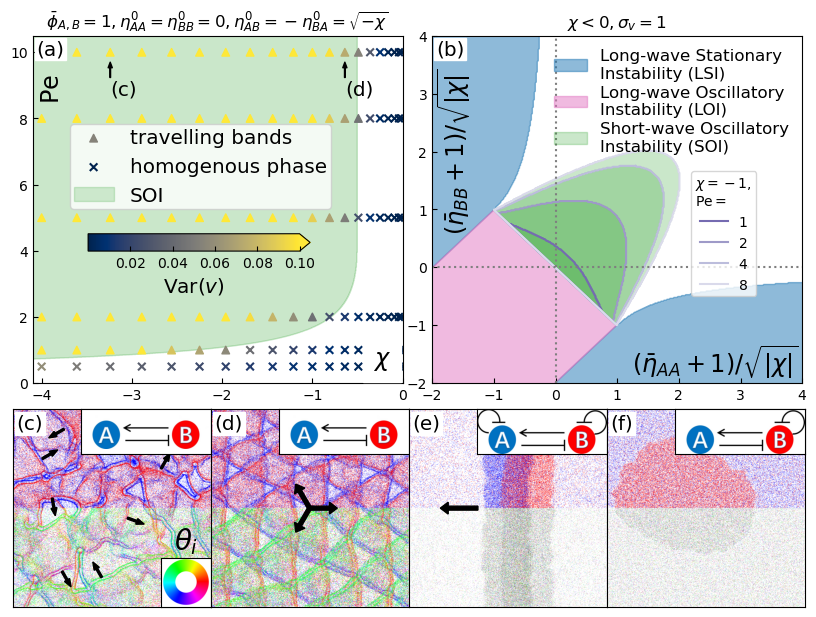

In [10]:
import matplotlib.patches as mpatches
from matplotlib import image as mpimg
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

fig = plt.figure(figsize=(8, 6))
subfigs = fig.subfigures(2, 1, wspace=0.001, hspace=0.001, height_ratios=[2, 1.05])
(ax1, ax2) = subfigs[0].subplots(1, 2)
xlim = [-2, 4]
ylim = [-2, 4]

PD_Pe_vs_chi(ax1)

Pe = 1
sigma_D=1
sigma_v = 1
wc = -1
extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
x, y = plot_PD_tilde_w1_w2(state, extent, xlim, ylim, ax=ax2, legend_loc=(0.28, 0.68), legend_font_size="medium")
cm = plt.cm.get_cmap('tab20c')
line, = ax2.plot(x, y, "-", c=cm.colors[12], label="%g" % Pe)
line_list = [line]
for i, Pe in enumerate([2, 4, 8]):
    extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
    x, y = plot_PD_tilde_w1_w2(state, extent, xlim, ylim, ax=ax2, only_SWO=True)
    line, = ax2.plot(x, y, c=cm.colors[i+13], label="%g" % Pe)
    line_list.append(line)
ax2.axhline(0, linestyle=":", color="tab:grey")
ax2.axvline(0, linestyle=":", color="tab:grey")
line_legend = ax2.legend(handles=line_list, title="$\\chi=-1,$\n${\\rm Pe}=$", loc=(0.7, 0.25), fontsize="medium", borderpad=0.3)
ax2.add_artist(line_legend)
patches = [mpatches.Patch(color='tab:blue', label='Long-wave Stationary\nInstability (LSI)', alpha=0.5),
           mpatches.Patch(color='tab:pink', label='Long-wave Oscillatory\nInstability (LOI)',alpha=0.5),
        #    mpatches.Patch(color='tab:orange', label='Short-wave\nStationary\nInstability (SSI)', alpha=0.5),
           mpatches.Patch(color='tab:green', label='Short-wave Oscillatory\nInstability (SOI)', alpha=0.25),
        ]
legend2 = ax2.legend(handles=patches, loc=(0.31, 0.64), fontsize="large", frameon=False, labelspacing=0.25)

ax1.set_title(r"$\bar{\phi}_{A,B}=1, \eta_{AA}^0=\eta_{BB}^0=0, \eta_{AB}^0=-\eta_{BA}^0=\sqrt{-\chi}$", fontsize="large")
ax2.set_title(r"$\chi<0, \sigma_v=1$", fontsize="large")

ax1.annotate('(c)', xy=(-1.8**2, 9.7), xytext=(-1.8**2, 8.7),
            arrowprops=dict(facecolor='black', width=0.5, headwidth=3, headlength=4), fontsize="x-large")
ax1.annotate('(d)', xy=(-0.8**2, 9.7), xytext=(-0.8**2, 8.7),
            arrowprops=dict(facecolor='black', width=0.5, headwidth=3, headlength=4), fontsize="x-large")
subfigs[0].subplots_adjust(left=0.03, bottom=0.05, right=0.992, top=0.933, wspace=0.08, hspace=0)


fig_dir = "/home/yduan/Desktop/NRQS1_Fig/fig1"
figs = ["TBC.png", "CS_w.png", "MTB.png", "SPS.png"]

axes = subfigs[1].subplots(1, 4)
ax3, ax4, ax5, ax6 = axes
for ax in axes:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
for i, ax in enumerate(axes):
    im = mpimg.imread(f"{fig_dir}/{figs[i]}")
    ax.imshow(im)

subfigs[1].subplots_adjust(wspace=0, hspace=0, left=0.005, bottom=-0.01, right=0.995, top=0.99)

bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.08")
ax1.text(0.01, 0.945, "(a)", fontsize="x-large", transform=ax1.transAxes, backgroundcolor="w", bbox=bbox)
ax2.text(0.01, 0.945, "(b)", fontsize="x-large", transform=ax2.transAxes, backgroundcolor="w", bbox=bbox)
labels = ["(c)", "(d)", "(e)", "(f)"]
markers = ["p", "H", "s", "o"]
colors = ["tab:green", "tab:green", "tab:pink", "tab:blue"]
for i, ax in enumerate(axes):
    ax.text(0.02, 0.9, labels[i], fontsize="x-large", transform=ax.transAxes, backgroundcolor="w", bbox=bbox)
    # ax_in = ax.inset_axes([0.88, 0.88, 0.12, 0.12])
    # ax_in.set_xticks([])
    # ax_in.set_yticks([])
    # ax_in.scatter(1, 1, s=65, c=colors[i], marker=markers[i], edgecolors="k")

width, height = 0.75/1.15, 0.26/1.15
ax_in = ax5.inset_axes([1-width, 1-height, width, height])
ax_in.set_aspect("equal")
ax_in.set_xticks([])
ax_in.set_yticks([])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/c2.jpg")
ax_in.imshow(im)
ax_in.set_ylim(477, 0)

ax_in = ax6.inset_axes([1-width, 1-height, width, height])
ax_in.set_aspect("equal")
ax_in.set_xticks([])
ax_in.set_yticks([])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/c1.jpg")
ax_in.imshow(im)
ax_in.set_ylim(477, 0)

ax_in = ax4.inset_axes([1-width, 1-height, width, height])
ax_in.set_aspect("equal")
ax_in.set_xticks([])
ax_in.set_yticks([])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/c0.jpg")
ax_in.imshow(im)
ax_in.set_ylim(477+50, 50)

ax_in = ax3.inset_axes([1-width, 1-height, width, height])
ax_in.set_aspect("equal")
ax_in.set_xticks([])
ax_in.set_yticks([])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/c0.jpg")
ax_in.imshow(im)
ax_in.set_ylim(477+50, 50)

# ax_in.set_ylim(ymax=-50)
# ax_in.set_xlim(xmax=-10)
# ax1.scatter(-1, 10, s=70, c="tab:green", marker="H", edgecolors="k", zorder=2.5)
# ax2.scatter(1, 1, s=70, c="tab:green", marker="H", edgecolors="k", zorder=2.5)
# ax1.scatter(-1.8**2, 10, s=70, c="tab:green", marker="p", edgecolors="k", zorder=2.5)
# ax2.scatter(-1, -1, s=60, c="tab:pink", marker="s", edgecolors="k")
# ax2.scatter(3, -1, s=60, c="tab:blue", marker="o", edgecolors="k")


# blue_circle = mlines.Line2D([], [], color="blue", marker="o", markersize=3, label="A", lw=0)
# red_circle = mlines.Line2D([], [], color="red", marker="o", markersize=3, label="B", lw=0)
# ax3.legend(handles=[blue_circle, red_circle], loc=(0.25, 0.71), fontsize="x-large", handletextpad=0., labelspacing=0.25, borderpad=0.3)


ax_cb = ax3.inset_axes([0.75, 0., 0.25, 0.25])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/circle2.png")
ax_cb.set_title(r"$\theta_i$", fontsize=20)
ax_cb.imshow(im)
ax_cb.set_xticks([])
ax_cb.set_yticks([])

label_font_size = "xx-large"
# xlabel = r"$\frac{(\bar{\eta}_{AA}+1)\sigma_v}{\sqrt{|\chi|}}$"
# ylabel = r"$\frac{\bar{\eta}_{BB}+1}{\sigma_v \sqrt{|\chi|}}$"
# xlabel = r"$\frac{\sigma_v}{\sqrt{|\chi|}} (\bar{\eta}_{AA}+1)$"
# ylabel = r"$\frac{1}{\sigma_v \sqrt{|\chi|}}(\bar{\eta}_{BB}+1)$"
xlabel = r"$(\bar{\eta}_{AA}+1)/\sqrt{|\chi|}$"
ylabel = r"$(\bar{\eta}_{BB}+1)/\sqrt{|\chi|}$"
bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.4")
ax1.text(0.92, 0.05, r"$\chi$", rotation=0, transform=ax1.transAxes, fontsize=label_font_size, backgroundcolor="w", bbox=bbox)
ax1.text(0.02, 0.82, r"${\rm Pe}$", rotation=90, transform=ax1.transAxes, fontsize=label_font_size)
ax2.text(0.54, 0.03, xlabel, rotation=0, transform=ax2.transAxes, fontsize=label_font_size)
ax2.text(0.01, 0.45, ylabel, rotation=90, transform=ax2.transAxes, fontsize=label_font_size)


ax5.arrow(0.35, 0.5, -0.15, 0, transform=ax5.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
ax4.arrow(0.50, 0.5, 0.1, 0, transform=ax4.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
ax4.arrow(0.50, 0.5, 0.1 * np.cos(-np.pi * 2 / 3), 0.1 * np.sin(-np.pi * 2 / 3), transform=ax4.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
ax4.arrow(0.50, 0.5, 0.1 * np.cos(np.pi * 2 / 3), 0.1 * np.sin(np.pi * 2 / 3), transform=ax4.transAxes, width=0.02, color="k", ec="k", head_length=0.04)

x = np.array([0.15, 0.2, 0.45, 0.25, 0.65, 0.75, 0.75, 0.58, 0.26, 0.45])
y = np.array([0.75, 0.55, 0.15, 0.18, 0.91, 0.8, 0.7, 0.45, 0.9, 0.88])
theta = np.array([30, -80, 120, -60, 10, 135, 60, -20, 210, 200], float)
theta *= np.pi/180
for i in range(x.size):
    ax3.arrow(x[i], y[i], 0.05 * np.cos(theta[i]), 0.05 * np.sin(theta[i]), transform=ax3.transAxes, width=0.01, color="k", ec="k", head_length=0.04)


plt.show()
# plt.savefig("fig/f1_v3.pdf", dpi=300)
plt.close()

[[8.3500e+01 0.0000e+00]
 [8.3500e+01 1.0000e+00]
 [8.3500e+01 2.0000e+00]
 ...
 [1.9970e+03 1.8995e+03]
 [1.9980e+03 1.8995e+03]
 [1.9990e+03 1.8995e+03]]
val: 5.839976049173856e-05 0.2478071002662182


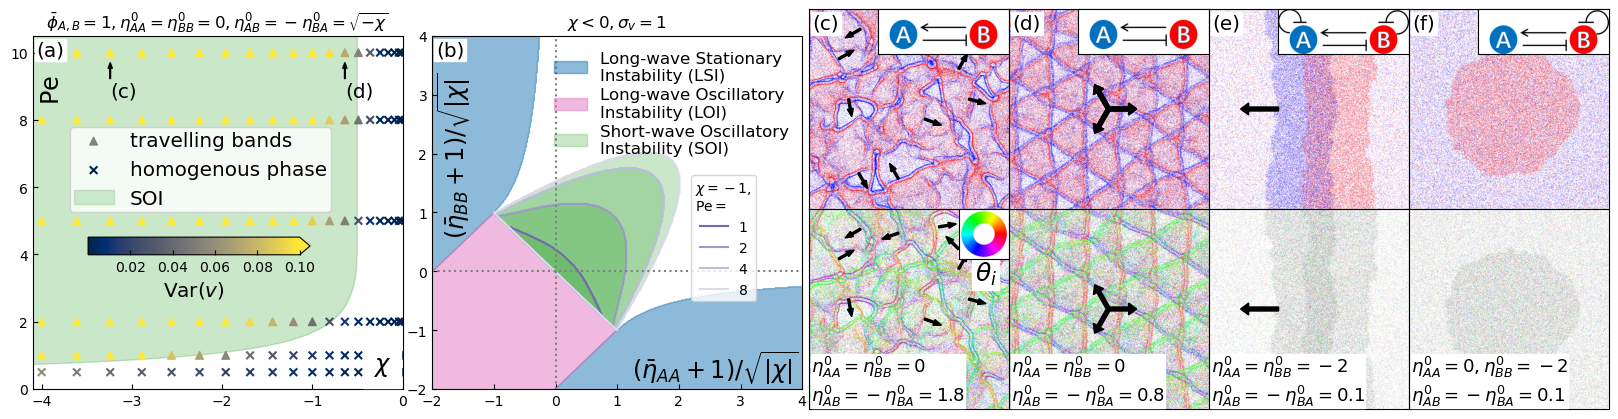

In [11]:
import matplotlib.patches as mpatches
from matplotlib import image as mpimg
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

fig = plt.figure(figsize=(16, 4))
subfigs = fig.subfigures(1, 2, wspace=0.001, hspace=0.001, width_ratios=[1, 1])
(ax1, ax2) = subfigs[0].subplots(1, 2)
xlim = [-2, 4]
ylim = [-2, 4]

PD_Pe_vs_chi(ax1)

Pe = 1
sigma_D=1
sigma_v = 1
wc = -1
extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
x, y = plot_PD_tilde_w1_w2(state, extent, xlim, ylim, ax=ax2, legend_loc=(0.28, 0.68), legend_font_size="medium")
cm = plt.cm.get_cmap('tab20c')
line, = ax2.plot(x, y, "-", c=cm.colors[12], label="%g" % Pe)
line_list = [line]
for i, Pe in enumerate([2, 4, 8]):
    extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
    x, y = plot_PD_tilde_w1_w2(state, extent, xlim, ylim, ax=ax2, only_SWO=True)
    line, = ax2.plot(x, y, c=cm.colors[i+13], label="%g" % Pe)
    line_list.append(line)
ax2.axhline(0, linestyle=":", color="tab:grey")
ax2.axvline(0, linestyle=":", color="tab:grey")
line_legend = ax2.legend(handles=line_list, title="$\\chi=-1,$\n${\\rm Pe}=$", loc=(0.7, 0.25), fontsize="medium", borderpad=0.3)
ax2.add_artist(line_legend)
patches = [mpatches.Patch(color='tab:blue', label='Long-wave Stationary\nInstability (LSI)', alpha=0.5),
           mpatches.Patch(color='tab:pink', label='Long-wave Oscillatory\nInstability (LOI)',alpha=0.5),
        #    mpatches.Patch(color='tab:orange', label='Short-wave\nStationary\nInstability (SSI)', alpha=0.5),
           mpatches.Patch(color='tab:green', label='Short-wave Oscillatory\nInstability (SOI)', alpha=0.25),
        ]
legend2 = ax2.legend(handles=patches, loc=(0.31, 0.64), fontsize="large", frameon=False, labelspacing=0.25)

ax1.set_title(r"$\bar{\phi}_{A,B}=1, \eta_{AA}^0=\eta_{BB}^0=0, \eta_{AB}^0=-\eta_{BA}^0=\sqrt{-\chi}$", fontsize="large")
ax2.set_title(r"$\chi<0, \sigma_v=1$", fontsize="large")

ax1.annotate('(c)', xy=(-1.8**2, 9.7), xytext=(-1.8**2, 8.7),
            arrowprops=dict(facecolor='black', width=0.5, headwidth=3, headlength=4), fontsize="x-large")
ax1.annotate('(d)', xy=(-0.8**2, 9.7), xytext=(-0.8**2, 8.7),
            arrowprops=dict(facecolor='black', width=0.5, headwidth=3, headlength=4), fontsize="x-large")
subfigs[0].subplots_adjust(left=0.03, bottom=0.05, right=0.992, top=0.933, wspace=0.08, hspace=0)


fig_dir = "/home/yduan/Desktop/NRQS1_Fig/fig1"
figs = ["TBC1.png", "CS1.png", "MTB1.png", "SPS1.png"]

axes = subfigs[1].subplots(2, 4)
ax3, ax4, ax5, ax6 = axes[0]
for ax in axes.flat:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
for i, ax in enumerate(axes[0]):
    im = mpimg.imread(f"{fig_dir}/{figs[i]}")
    ax.imshow(im)


im = mpimg.imread(f"{fig_dir}/MTB3.png")
axes[1, 2].imshow(im)
im = mpimg.imread(f"{fig_dir}/CS3.png")
axes[1, 1].imshow(im)
im = mpimg.imread(f"{fig_dir}/TBC3.png")
axes[1, 0].imshow(im)
im = mpimg.imread(f"{fig_dir}/SPS2.png")
axes[1, 3].imshow(im)
subfigs[1].subplots_adjust(wspace=0, hspace=0, left=0, bottom=0, right=1, top=1)

bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.08")
ax1.text(0.01, 0.945, "(a)", fontsize="x-large", transform=ax1.transAxes, backgroundcolor="w", bbox=bbox)
ax2.text(0.01, 0.945, "(b)", fontsize="x-large", transform=ax2.transAxes, backgroundcolor="w", bbox=bbox)
labels = ["(c)", "(d)", "(e)", "(f)"]
markers = ["p", "H", "s", "o"]
colors = ["tab:green", "tab:green", "tab:pink", "tab:blue"]
for i, ax in enumerate(axes[0]):
    ax.text(0.02, 0.9, labels[i], fontsize="x-large", transform=ax.transAxes, backgroundcolor="w", bbox=bbox)
    # ax_in = ax.inset_axes([0.88, 0.88, 0.12, 0.12])
    # ax_in.set_xticks([])
    # ax_in.set_yticks([])
    # ax_in.scatter(1, 1, s=65, c=colors[i], marker=markers[i], edgecolors="k")

width, height = 0.75/1.15, 0.26/1.15
ax_in = ax5.inset_axes([1-width, 1-height, width, height])
ax_in.set_aspect("equal")
ax_in.set_xticks([])
ax_in.set_yticks([])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/c2.jpg")
ax_in.imshow(im)
ax_in.set_ylim(477, 0)

ax_in = ax6.inset_axes([1-width, 1-height, width, height])
ax_in.set_aspect("equal")
ax_in.set_xticks([])
ax_in.set_yticks([])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/c1.jpg")
ax_in.imshow(im)
ax_in.set_ylim(477, 0)

ax_in = ax4.inset_axes([1-width, 1-height, width, height])
ax_in.set_aspect("equal")
ax_in.set_xticks([])
ax_in.set_yticks([])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/c0.jpg")
ax_in.imshow(im)
ax_in.set_ylim(477+50, 50)

ax_in = ax3.inset_axes([1-width, 1-height, width, height])
ax_in.set_aspect("equal")
ax_in.set_xticks([])
ax_in.set_yticks([])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/c0.jpg")
ax_in.imshow(im)
ax_in.set_ylim(477+50, 50)

# ax_in.set_ylim(ymax=-50)
# ax_in.set_xlim(xmax=-10)
# ax1.scatter(-1, 10, s=70, c="tab:green", marker="H", edgecolors="k", zorder=2.5)
# ax2.scatter(1, 1, s=70, c="tab:green", marker="H", edgecolors="k", zorder=2.5)
# ax1.scatter(-1.8**2, 10, s=70, c="tab:green", marker="p", edgecolors="k", zorder=2.5)
# ax2.scatter(-1, -1, s=60, c="tab:pink", marker="s", edgecolors="k")
# ax2.scatter(3, -1, s=60, c="tab:blue", marker="o", edgecolors="k")


# blue_circle = mlines.Line2D([], [], color="blue", marker="o", markersize=3, label="A", lw=0)
# red_circle = mlines.Line2D([], [], color="red", marker="o", markersize=3, label="B", lw=0)
# ax3.legend(handles=[blue_circle, red_circle], loc=(0.25, 0.71), fontsize="x-large", handletextpad=0., labelspacing=0.25, borderpad=0.3)


ax_cb = axes[1, 0].inset_axes([0.75, 0.75, 0.25, 0.25])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/circle2.png")
# ax_cb.set_title(r"$\theta_i$", fontsize=20)
ax_cb.imshow(im)
ax_cb.set_xticks([])
ax_cb.set_yticks([])

label_font_size = "xx-large"
# xlabel = r"$\frac{(\bar{\eta}_{AA}+1)\sigma_v}{\sqrt{|\chi|}}$"
# ylabel = r"$\frac{\bar{\eta}_{BB}+1}{\sigma_v \sqrt{|\chi|}}$"
# xlabel = r"$\frac{\sigma_v}{\sqrt{|\chi|}} (\bar{\eta}_{AA}+1)$"
# ylabel = r"$\frac{1}{\sigma_v \sqrt{|\chi|}}(\bar{\eta}_{BB}+1)$"
xlabel = r"$(\bar{\eta}_{AA}+1)/\sqrt{|\chi|}$"
ylabel = r"$(\bar{\eta}_{BB}+1)/\sqrt{|\chi|}$"
bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.4")
ax1.text(0.92, 0.05, r"$\chi$", rotation=0, transform=ax1.transAxes, fontsize=label_font_size, backgroundcolor="w", bbox=bbox)
ax1.text(0.02, 0.82, r"${\rm Pe}$", rotation=90, transform=ax1.transAxes, fontsize=label_font_size)
ax2.text(0.54, 0.03, xlabel, rotation=0, transform=ax2.transAxes, fontsize=label_font_size)
ax2.text(0.01, 0.45, ylabel, rotation=90, transform=ax2.transAxes, fontsize=label_font_size)

bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0")
axes[1, 2].text(0.01, 0.04, "$\\eta_{AA}^0=\\eta_{BB}^0=-2$\n$\\eta_{AB}^0=-\\eta_{BA}^0=0.1$", transform=axes[1, 2].transAxes, fontsize=13, backgroundcolor="w", bbox=bbox)
axes[1, 3].text(0.01, 0.04, "$\\eta_{AA}^0=0,\\eta_{BB}^0=-2$\n$\\eta_{AB}^0=-\\eta_{BA}^0=0.1$", transform=axes[1, 3].transAxes, fontsize=13, backgroundcolor="w", bbox=bbox)
axes[1, 1].text(0.01, 0.04, "$\\eta_{AA}^0=\\eta_{BB}^0=0$\n$\\eta_{AB}^0=-\\eta_{BA}^0=0.8$", transform=axes[1, 1].transAxes, fontsize=13, backgroundcolor="w", bbox=bbox)
axes[1, 0].text(0.01, 0.04, "$\\eta_{AA}^0=\\eta_{BB}^0=0$\n$\\eta_{AB}^0=-\\eta_{BA}^0=1.8$", transform=axes[1, 0].transAxes, fontsize=13, backgroundcolor="w", bbox=bbox)
bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.1")
axes[1, 0].text(0.83, 0.64, "$\\theta_i$", transform=axes[1, 0].transAxes, fontsize=18, backgroundcolor="w", bbox=bbox)
ax5.arrow(0.35, 0.5, -0.15, 0, transform=ax5.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
ax4.arrow(0.50, 0.5, 0.1, 0, transform=ax4.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
ax4.arrow(0.50, 0.5, 0.1 * np.cos(-np.pi * 2 / 3), 0.1 * np.sin(-np.pi * 2 / 3), transform=ax4.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
ax4.arrow(0.50, 0.5, 0.1 * np.cos(np.pi * 2 / 3), 0.1 * np.sin(np.pi * 2 / 3), transform=ax4.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
axes[1, 2].arrow(0.35, 0.5, -0.15, 0, transform=axes[1, 2].transAxes, width=0.02, color="k", ec="k", head_length=0.04)
for ax in axes[:, 1]:
    ax.arrow(0.50, 0.5, 0.1, 0, transform=ax.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
    ax.arrow(0.50, 0.5, 0.1 * np.cos(-np.pi * 2 / 3), 0.1 * np.sin(-np.pi * 2 / 3), transform=ax.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
    ax.arrow(0.50, 0.5, 0.1 * np.cos(np.pi * 2 / 3), 0.1 * np.sin(np.pi * 2 / 3), transform=ax.transAxes, width=0.02, color="k", ec="k", head_length=0.04)

x = np.array([0.15, 0.2, 0.45, 0.25, 0.65, 0.75, 0.75, 0.58, 0.26, 0.45, 0.8])
y = np.array([0.75, 0.55, 0.15, 0.18, 0.91, 0.8, 0.7, 0.45, 0.9, 0.88, 0.55])
theta = np.array([30, -80, 120, -60, 10, 135, 60, -20, 210, 200, -15], float)
theta *= np.pi/180
for i in range(x.size):
    ax3.arrow(x[i], y[i], 0.05 * np.cos(theta[i]), 0.05 * np.sin(theta[i]), transform=ax3.transAxes, width=0.01, color="k", ec="k", head_length=0.04)
    axes[1, 0].arrow(x[i], y[i], 0.05 * np.cos(theta[i]), 0.05 * np.sin(theta[i]), transform=axes[1,0].transAxes, width=0.01, color="k", ec="k", head_length=0.04)

plt.show()
# plt.savefig("fig/f1_v3_two_col.pdf", dpi=300)
plt.close()

[[8.3500e+01 0.0000e+00]
 [8.3500e+01 1.0000e+00]
 [8.3500e+01 2.0000e+00]
 ...
 [1.9970e+03 1.8995e+03]
 [1.9980e+03 1.8995e+03]
 [1.9990e+03 1.8995e+03]]
val: 5.839976049173856e-05 0.2478071002662182


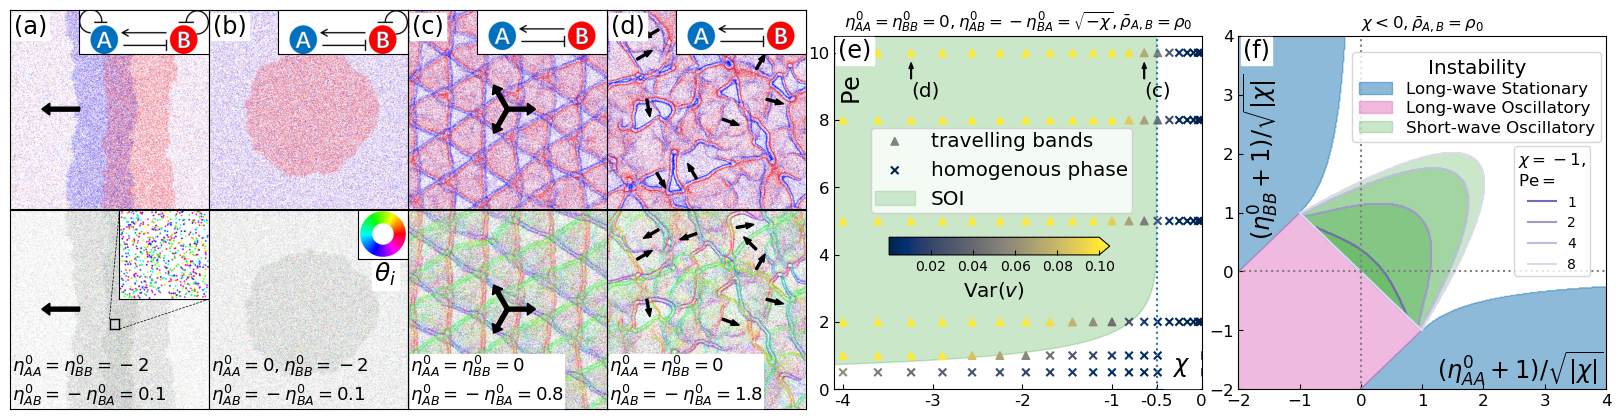

In [12]:
import matplotlib.patches as mpatches
from matplotlib import image as mpimg
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

fig = plt.figure(figsize=(16, 4))
subfigs = fig.subfigures(1, 2, wspace=0.001, hspace=0.001, width_ratios=[1, 1])
(ax1, ax2) = subfigs[1].subplots(1, 2)
xlim = [-2, 4]
ylim = [-2, 4]

PD_Pe_vs_chi(ax1)

Pe = 1
sigma_D=1
sigma_v = 1
wc = -1
extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
x, y = plot_PD_tilde_w1_w2(state, extent, xlim, ylim, ax=ax2, legend_loc=(0.28, 0.68), legend_font_size="medium")
cm = plt.cm.get_cmap('tab20c')
line, = ax2.plot(x, y, "-", c=cm.colors[12], label="%g" % Pe)
line_list = [line]
for i, Pe in enumerate([2, 4, 8]):
    extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
    x, y = plot_PD_tilde_w1_w2(state, extent, xlim, ylim, ax=ax2, only_SWO=True)
    line, = ax2.plot(x, y, c=cm.colors[i+13], label="%g" % Pe)
    line_list.append(line)
ax2.axhline(0, linestyle=":", color="tab:grey")
ax2.axvline(0, linestyle=":", color="tab:grey")
line_legend = ax2.legend(handles=line_list, title="$\\chi=-1,$\n${\\rm Pe}=$", loc=(0.75, 0.32), fontsize="medium", borderpad=0.3, title_fontsize="large")
ax2.add_artist(line_legend)
patches = [mpatches.Patch(color='tab:blue', label='Long-wave Stationary', alpha=0.5),
           mpatches.Patch(color='tab:pink', label='Long-wave Oscillatory',alpha=0.5),
        #    mpatches.Patch(color='tab:orange', label='Short-wave\nStationary\nInstability (SSI)', alpha=0.5),
           mpatches.Patch(color='tab:green', label='Short-wave Oscillatory', alpha=0.25),
        ]
legend2 = ax2.legend(handles=patches, loc=(0.31, 0.7), fontsize="large", frameon=True, labelspacing=0.25, title="Instability", title_fontsize="x-large")

ax1.set_title(r"$\eta_{AA}^0=\eta_{BB}^0=0, \eta_{AB}^0=-\eta_{BA}^0=\sqrt{-\chi},\bar{\rho}_{A,B}=\rho_0$", fontsize="large")
ax2.set_title(r"$\chi<0, \bar{\rho}_{A,B}=\rho_0$", fontsize="large")
ax1.axvline(-0.5, linestyle="dotted", c="tab:blue")
xticks = [-4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0]
ax1.set_xticks(xticks)
ax1.set_xticklabels(["%g" % i for i in xticks])
ax1.annotate('(d)', xy=(-1.8**2, 9.7), xytext=(-1.8**2, 8.7),
            arrowprops=dict(facecolor='black', width=0.5, headwidth=3, headlength=4), fontsize="x-large")
ax1.annotate('(c)', xy=(-0.8**2, 9.7), xytext=(-0.8**2, 8.7),
            arrowprops=dict(facecolor='black', width=0.5, headwidth=3, headlength=4), fontsize="x-large")
subfigs[1].subplots_adjust(left=0.03, bottom=0.05, right=0.995, top=0.933, wspace=0.1, hspace=0)


fig_dir = "/home/yduan/Desktop/NRQS1_Fig/fig1"
figs = ["MTB1.png", "SPS1.png", "CS1.png", "TBC1.png"]

axes = subfigs[0].subplots(2, 4)
ax3, ax4, ax5, ax6 = axes[0]
for ax in axes.flat:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
for i, ax in enumerate(axes[0]):
    im = mpimg.imread(f"{fig_dir}/{figs[i]}")
    ax.imshow(im)


im = mpimg.imread(f"{fig_dir}/MTB3.png")
axes[1, 0].imshow(im, extent=[0, 1, 0, 1])
im = mpimg.imread(f"{fig_dir}/CS3.png")
axes[1, 2].imshow(im)
im = mpimg.imread(f"{fig_dir}/TBC3.png")
axes[1, 3].imshow(im)
im = mpimg.imread(f"{fig_dir}/SPS2.png")
axes[1, 1].imshow(im)
subfigs[0].subplots_adjust(wspace=0, hspace=0, left=0, bottom=0, right=0.995, top=1)

bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.08")
ax1.text(0.012, 0.938, "(e)", fontsize="xx-large", transform=ax1.transAxes, backgroundcolor="w", bbox=bbox)
ax2.text(0.012, 0.938, "(f)", fontsize="xx-large", transform=ax2.transAxes, backgroundcolor="w", bbox=bbox)
labels = ["(a)", "(b)", "(c)", "(d)"]
markers = ["p", "H", "s", "o"]
colors = ["tab:green", "tab:green", "tab:pink", "tab:blue"]
for i, ax in enumerate(axes[0]):
    ax.text(0.02, 0.88, labels[i], fontsize="xx-large", transform=ax.transAxes, backgroundcolor="w", bbox=bbox)
    # ax_in = ax.inset_axes([0.88, 0.88, 0.12, 0.12])
    # ax_in.set_xticks([])
    # ax_in.set_yticks([])
    # ax_in.scatter(1, 1, s=65, c=colors[i], marker=markers[i], edgecolors="k")

width, height = 0.75/1.15, 0.26/1.15
ax_in = ax3.inset_axes([1-width, 1-height, width, height])
ax_in.set_aspect("equal")
ax_in.set_xticks([])
ax_in.set_yticks([])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/c2.jpg")
ax_in.imshow(im)
ax_in.set_ylim(477, 0)

ax_in = ax4.inset_axes([1-width, 1-height, width, height])
ax_in.set_aspect("equal")
ax_in.set_xticks([])
ax_in.set_yticks([])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/c1.jpg")
ax_in.imshow(im)
ax_in.set_ylim(477, 0)

ax_in = ax5.inset_axes([1-width, 1-height, width, height])
ax_in.set_aspect("equal")
ax_in.set_xticks([])
ax_in.set_yticks([])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/c0.jpg")
ax_in.imshow(im)
ax_in.set_ylim(477+50, 50)

ax_in = ax6.inset_axes([1-width, 1-height, width, height])
ax_in.set_aspect("equal")
ax_in.set_xticks([])
ax_in.set_yticks([])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/c0.jpg")
ax_in.imshow(im)
ax_in.set_ylim(477+50, 50)

# ax_in.set_ylim(ymax=-50)
# ax_in.set_xlim(xmax=-10)
# ax1.scatter(-1, 10, s=70, c="tab:green", marker="H", edgecolors="k", zorder=2.5)
# ax2.scatter(1, 1, s=70, c="tab:green", marker="H", edgecolors="k", zorder=2.5)
# ax1.scatter(-1.8**2, 10, s=70, c="tab:green", marker="p", edgecolors="k", zorder=2.5)
# ax2.scatter(-1, -1, s=60, c="tab:pink", marker="s", edgecolors="k")
# ax2.scatter(3, -1, s=60, c="tab:blue", marker="o", edgecolors="k")


# blue_circle = mlines.Line2D([], [], color="blue", marker="o", markersize=3, label="A", lw=0)
# red_circle = mlines.Line2D([], [], color="red", marker="o", markersize=3, label="B", lw=0)
# ax3.legend(handles=[blue_circle, red_circle], loc=(0.25, 0.71), fontsize="x-large", handletextpad=0., labelspacing=0.25, borderpad=0.3)


ax_cb = axes[1, 1].inset_axes([0.75, 0.75, 0.25, 0.25])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/circle2.png")
# ax_cb.set_title(r"$\theta_i$", fontsize=20)
ax_cb.imshow(im)
ax_cb.set_xticks([])
ax_cb.set_yticks([])

ax_zoom = axes[1, 0].inset_axes([0.55, 0.55, 0.45, 0.45])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/band_zoom3.png")
ax_zoom.imshow(im)
ax_zoom.set_xticks([])
ax_zoom.set_yticks([])
axes[1, 0].axhline(0.4, 0.5, 0.5+2/40, c="k", lw=1)
axes[1, 0].axhline(0.4 + 2/40, 0.5, 0.5+2/40, c="k", lw=1)
axes[1, 0].axvline(0.5, 0.4, 0.4+2/40, c="k", lw=1)
axes[1, 0].axvline(0.5 + 2/40, 0.4, 0.4+2/40, c="k", lw=1)
axes[1, 0].plot([0.5, 0.55], [0.4+2/40, 1], linestyle="dashed", c="k", lw=0.5)
axes[1, 0].plot([0.5+2/40, 1], [0.4, 0.55], linestyle="dashed", c="k", lw=0.5)



label_font_size = "xx-large"
# xlabel = r"$\frac{(\bar{\eta}_{AA}+1)\sigma_v}{\sqrt{|\chi|}}$"
# ylabel = r"$\frac{\bar{\eta}_{BB}+1}{\sigma_v \sqrt{|\chi|}}$"
# xlabel = r"$\frac{\sigma_v}{\sqrt{|\chi|}} (\bar{\eta}_{AA}+1)$"
# ylabel = r"$\frac{1}{\sigma_v \sqrt{|\chi|}}(\bar{\eta}_{BB}+1)$"
xlabel = r"$(\eta^0_{AA}+1)/\sqrt{|\chi|}$"
ylabel = r"$(\eta^0_{BB}+1)/\sqrt{|\chi|}$"
bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.4")
ax1.text(0.92, 0.05, r"$\chi$", rotation=0, transform=ax1.transAxes, fontsize=label_font_size, backgroundcolor="w", bbox=bbox)
ax1.text(0.02, 0.82, r"${\rm Pe}$", rotation=90, transform=ax1.transAxes, fontsize=label_font_size)
ax2.text(0.54, 0.03, xlabel, rotation=0, transform=ax2.transAxes, fontsize=label_font_size)
ax2.text(0.01, 0.45, ylabel, rotation=90, transform=ax2.transAxes, fontsize=label_font_size)
ax1.set_xticks([-4, -3, -2, -1, -0.5, 0])
ax1.tick_params(labelsize='large')
ax2.tick_params(labelsize='large')

# ax1.set_yticks([0, 2, 4, 6, 8, 10], labelsize="x-large")


bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0")
axes[1, 0].text(0.01, 0.04, "$\\eta_{AA}^0=\\eta_{BB}^0=-2$\n$\\eta_{AB}^0=-\\eta_{BA}^0=0.1$", transform=axes[1, 0].transAxes, fontsize=13)
axes[1, 1].text(0.01, 0.04, "$\\eta_{AA}^0=0,\\eta_{BB}^0=-2$\n$\\eta_{AB}^0=-\\eta_{BA}^0=0.1$", transform=axes[1, 1].transAxes, fontsize=13)
axes[1, 2].text(0.01, 0.04, "$\\eta_{AA}^0=\\eta_{BB}^0=0$\n$\\eta_{AB}^0=-\\eta_{BA}^0=0.8$", transform=axes[1, 2].transAxes, fontsize=13, backgroundcolor="w", bbox=bbox)
axes[1, 3].text(0.01, 0.04, "$\\eta_{AA}^0=\\eta_{BB}^0=0$\n$\\eta_{AB}^0=-\\eta_{BA}^0=1.8$", transform=axes[1, 3].transAxes, fontsize=13, backgroundcolor="w", bbox=bbox)
bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.1")
axes[1, 1].text(0.83, 0.64, "$\\theta_i$", transform=axes[1, 1].transAxes, fontsize=18, backgroundcolor="w", bbox=bbox)
# ax5.arrow(0.35, 0.5, -0.15, 0, transform=ax5.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
# ax4.arrow(0.50, 0.5, 0.1, 0, transform=ax4.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
# ax4.arrow(0.50, 0.5, 0.1 * np.cos(-np.pi * 2 / 3), 0.1 * np.sin(-np.pi * 2 / 3), transform=ax4.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
# ax4.arrow(0.50, 0.5, 0.1 * np.cos(np.pi * 2 / 3), 0.1 * np.sin(np.pi * 2 / 3), transform=ax4.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
axes[1, 0].arrow(0.35, 0.5, -0.15, 0, transform=axes[1, 0].transAxes, width=0.02, color="k", ec="k", head_length=0.04)
axes[0, 0].arrow(0.35, 0.5, -0.15, 0, transform=axes[0, 0].transAxes, width=0.02, color="k", ec="k", head_length=0.04)

for ax in axes[:, 2]:
    ax.arrow(0.50, 0.5, 0.1, 0, transform=ax.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
    ax.arrow(0.50, 0.5, 0.1 * np.cos(-np.pi * 2 / 3), 0.1 * np.sin(-np.pi * 2 / 3), transform=ax.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
    ax.arrow(0.50, 0.5, 0.1 * np.cos(np.pi * 2 / 3), 0.1 * np.sin(np.pi * 2 / 3), transform=ax.transAxes, width=0.02, color="k", ec="k", head_length=0.04)

x = np.array([0.15, 0.2, 0.45, 0.25, 0.65, 0.75, 0.75, 0.58, 0.26, 0.45, 0.8])
y = np.array([0.75, 0.55, 0.15, 0.18, 0.91, 0.8, 0.7, 0.45, 0.9, 0.88, 0.55])
theta = np.array([30, -80, 120, -60, 10, 135, 60, -20, 210, 200, -15], float)
theta *= np.pi/180
for i in range(x.size):
    axes[0, 3].arrow(x[i], y[i], 0.05 * np.cos(theta[i]), 0.05 * np.sin(theta[i]), transform=axes[0, 3].transAxes, width=0.01, color="k", ec="k", head_length=0.04)
    axes[1, 3].arrow(x[i], y[i], 0.05 * np.cos(theta[i]), 0.05 * np.sin(theta[i]), transform=axes[1,3].transAxes, width=0.01, color="k", ec="k", head_length=0.04)

plt.show()
# plt.savefig("fig/press_release.pdf", dpi=300)
plt.close()

[[8.3500e+01 0.0000e+00]
 [8.3500e+01 1.0000e+00]
 [8.3500e+01 2.0000e+00]
 ...
 [1.9970e+03 1.8995e+03]
 [1.9980e+03 1.8995e+03]
 [1.9990e+03 1.8995e+03]]
val: 5.839976049173856e-05 0.2478071002662182


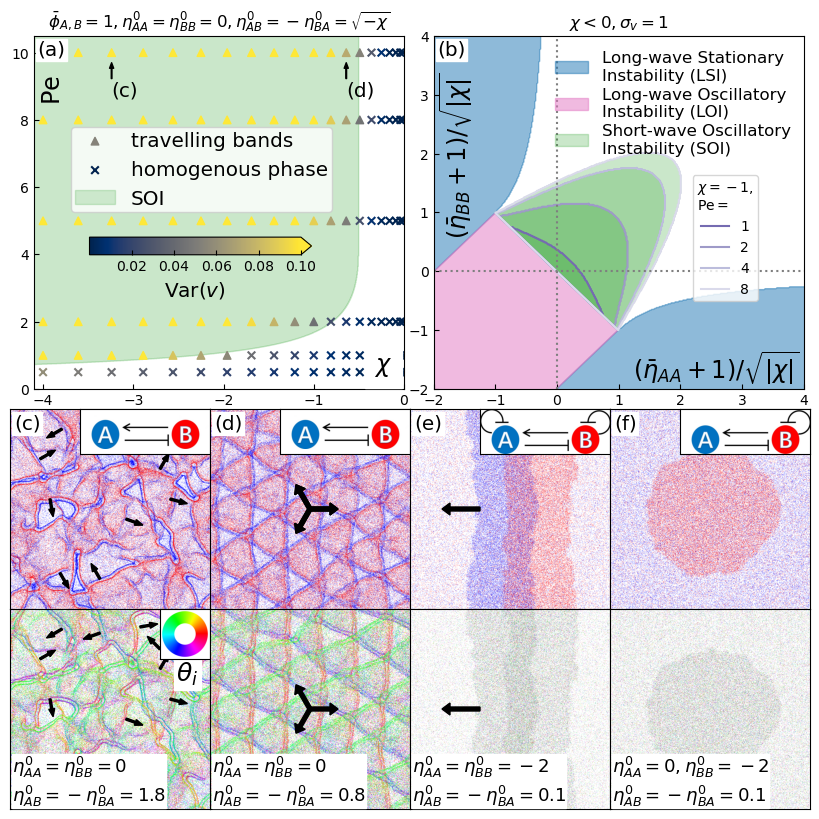

In [13]:
import matplotlib.patches as mpatches
from matplotlib import image as mpimg
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

fig = plt.figure(figsize=(8, 8))
subfigs = fig.subfigures(2, 1, wspace=0.001, hspace=0.001, height_ratios=[1, 1])
(ax1, ax2) = subfigs[0].subplots(1, 2)
xlim = [-2, 4]
ylim = [-2, 4]

PD_Pe_vs_chi(ax1)

Pe = 1
sigma_D=1
sigma_v = 1
wc = -1
extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
x, y = plot_PD_tilde_w1_w2(state, extent, xlim, ylim, ax=ax2, legend_loc=(0.28, 0.68), legend_font_size="medium")
cm = plt.cm.get_cmap('tab20c')
line, = ax2.plot(x, y, "-", c=cm.colors[12], label="%g" % Pe)
line_list = [line]
for i, Pe in enumerate([2, 4, 8]):
    extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
    x, y = plot_PD_tilde_w1_w2(state, extent, xlim, ylim, ax=ax2, only_SWO=True)
    line, = ax2.plot(x, y, c=cm.colors[i+13], label="%g" % Pe)
    line_list.append(line)
ax2.axhline(0, linestyle=":", color="tab:grey")
ax2.axvline(0, linestyle=":", color="tab:grey")
line_legend = ax2.legend(handles=line_list, title="$\\chi=-1,$\n${\\rm Pe}=$", loc=(0.7, 0.25), fontsize="medium", borderpad=0.3)
ax2.add_artist(line_legend)
patches = [mpatches.Patch(color='tab:blue', label='Long-wave Stationary\nInstability (LSI)', alpha=0.5),
           mpatches.Patch(color='tab:pink', label='Long-wave Oscillatory\nInstability (LOI)',alpha=0.5),
        #    mpatches.Patch(color='tab:orange', label='Short-wave\nStationary\nInstability (SSI)', alpha=0.5),
           mpatches.Patch(color='tab:green', label='Short-wave Oscillatory\nInstability (SOI)', alpha=0.25),
        ]
legend2 = ax2.legend(handles=patches, loc=(0.31, 0.64), fontsize="large", frameon=False, labelspacing=0.25)

ax1.set_title(r"$\bar{\phi}_{A,B}=1, \eta_{AA}^0=\eta_{BB}^0=0, \eta_{AB}^0=-\eta_{BA}^0=\sqrt{-\chi}$", fontsize="large")
ax2.set_title(r"$\chi<0, \sigma_v=1$", fontsize="large")

ax1.annotate('(c)', xy=(-1.8**2, 9.7), xytext=(-1.8**2, 8.7),
            arrowprops=dict(facecolor='black', width=0.5, headwidth=3, headlength=4), fontsize="x-large")
ax1.annotate('(d)', xy=(-0.8**2, 9.7), xytext=(-0.8**2, 8.7),
            arrowprops=dict(facecolor='black', width=0.5, headwidth=3, headlength=4), fontsize="x-large")
subfigs[0].subplots_adjust(left=0.03, bottom=0.05, right=0.992, top=0.933, wspace=0.08, hspace=0)


fig_dir = "/home/yduan/Desktop/NRQS1_Fig/fig1"
figs = ["TBC1.png", "CS1.png", "MTB1.png", "SPS1.png"]

axes = subfigs[1].subplots(2, 4)
ax3, ax4, ax5, ax6 = axes[0]
for ax in axes.flat:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
for i, ax in enumerate(axes[0]):
    im = mpimg.imread(f"{fig_dir}/{figs[i]}")
    ax.imshow(im)


im = mpimg.imread(f"{fig_dir}/MTB3.png")
axes[1, 2].imshow(im)
im = mpimg.imread(f"{fig_dir}/CS3.png")
axes[1, 1].imshow(im)
im = mpimg.imread(f"{fig_dir}/TBC3.png")
axes[1, 0].imshow(im)
im = mpimg.imread(f"{fig_dir}/SPS2.png")
axes[1, 3].imshow(im)
subfigs[1].subplots_adjust(wspace=0, hspace=0, left=0, bottom=0, right=1, top=1)

bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.08")
ax1.text(0.01, 0.945, "(a)", fontsize="x-large", transform=ax1.transAxes, backgroundcolor="w", bbox=bbox)
ax2.text(0.01, 0.945, "(b)", fontsize="x-large", transform=ax2.transAxes, backgroundcolor="w", bbox=bbox)
labels = ["(c)", "(d)", "(e)", "(f)"]
markers = ["p", "H", "s", "o"]
colors = ["tab:green", "tab:green", "tab:pink", "tab:blue"]
for i, ax in enumerate(axes[0]):
    ax.text(0.02, 0.9, labels[i], fontsize="x-large", transform=ax.transAxes, backgroundcolor="w", bbox=bbox)
    # ax_in = ax.inset_axes([0.88, 0.88, 0.12, 0.12])
    # ax_in.set_xticks([])
    # ax_in.set_yticks([])
    # ax_in.scatter(1, 1, s=65, c=colors[i], marker=markers[i], edgecolors="k")

width, height = 0.75/1.15, 0.26/1.15
ax_in = ax5.inset_axes([1-width, 1-height, width, height])
ax_in.set_aspect("equal")
ax_in.set_xticks([])
ax_in.set_yticks([])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/c2.jpg")
ax_in.imshow(im)
ax_in.set_ylim(477, 0)

ax_in = ax6.inset_axes([1-width, 1-height, width, height])
ax_in.set_aspect("equal")
ax_in.set_xticks([])
ax_in.set_yticks([])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/c1.jpg")
ax_in.imshow(im)
ax_in.set_ylim(477, 0)

ax_in = ax4.inset_axes([1-width, 1-height, width, height])
ax_in.set_aspect("equal")
ax_in.set_xticks([])
ax_in.set_yticks([])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/c0.jpg")
ax_in.imshow(im)
ax_in.set_ylim(477+50, 50)

ax_in = ax3.inset_axes([1-width, 1-height, width, height])
ax_in.set_aspect("equal")
ax_in.set_xticks([])
ax_in.set_yticks([])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/c0.jpg")
ax_in.imshow(im)
ax_in.set_ylim(477+50, 50)

# ax_in.set_ylim(ymax=-50)
# ax_in.set_xlim(xmax=-10)
# ax1.scatter(-1, 10, s=70, c="tab:green", marker="H", edgecolors="k", zorder=2.5)
# ax2.scatter(1, 1, s=70, c="tab:green", marker="H", edgecolors="k", zorder=2.5)
# ax1.scatter(-1.8**2, 10, s=70, c="tab:green", marker="p", edgecolors="k", zorder=2.5)
# ax2.scatter(-1, -1, s=60, c="tab:pink", marker="s", edgecolors="k")
# ax2.scatter(3, -1, s=60, c="tab:blue", marker="o", edgecolors="k")


# blue_circle = mlines.Line2D([], [], color="blue", marker="o", markersize=3, label="A", lw=0)
# red_circle = mlines.Line2D([], [], color="red", marker="o", markersize=3, label="B", lw=0)
# ax3.legend(handles=[blue_circle, red_circle], loc=(0.25, 0.71), fontsize="x-large", handletextpad=0., labelspacing=0.25, borderpad=0.3)


ax_cb = axes[1, 0].inset_axes([0.75, 0.75, 0.25, 0.25])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/circle2.png")
# ax_cb.set_title(r"$\theta_i$", fontsize=20)
ax_cb.imshow(im)
ax_cb.set_xticks([])
ax_cb.set_yticks([])

label_font_size = "xx-large"
# xlabel = r"$\frac{(\bar{\eta}_{AA}+1)\sigma_v}{\sqrt{|\chi|}}$"
# ylabel = r"$\frac{\bar{\eta}_{BB}+1}{\sigma_v \sqrt{|\chi|}}$"
# xlabel = r"$\frac{\sigma_v}{\sqrt{|\chi|}} (\bar{\eta}_{AA}+1)$"
# ylabel = r"$\frac{1}{\sigma_v \sqrt{|\chi|}}(\bar{\eta}_{BB}+1)$"
xlabel = r"$(\bar{\eta}_{AA}+1)/\sqrt{|\chi|}$"
ylabel = r"$(\bar{\eta}_{BB}+1)/\sqrt{|\chi|}$"
bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.4")
ax1.text(0.92, 0.05, r"$\chi$", rotation=0, transform=ax1.transAxes, fontsize=label_font_size, backgroundcolor="w", bbox=bbox)
ax1.text(0.02, 0.82, r"${\rm Pe}$", rotation=90, transform=ax1.transAxes, fontsize=label_font_size)
ax2.text(0.54, 0.03, xlabel, rotation=0, transform=ax2.transAxes, fontsize=label_font_size)
ax2.text(0.01, 0.45, ylabel, rotation=90, transform=ax2.transAxes, fontsize=label_font_size)

bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0")
axes[1, 2].text(0.01, 0.04, "$\\eta_{AA}^0=\\eta_{BB}^0=-2$\n$\\eta_{AB}^0=-\\eta_{BA}^0=0.1$", transform=axes[1, 2].transAxes, fontsize=13, backgroundcolor="w", bbox=bbox)
axes[1, 3].text(0.01, 0.04, "$\\eta_{AA}^0=0,\\eta_{BB}^0=-2$\n$\\eta_{AB}^0=-\\eta_{BA}^0=0.1$", transform=axes[1, 3].transAxes, fontsize=13, backgroundcolor="w", bbox=bbox)
axes[1, 1].text(0.01, 0.04, "$\\eta_{AA}^0=\\eta_{BB}^0=0$\n$\\eta_{AB}^0=-\\eta_{BA}^0=0.8$", transform=axes[1, 1].transAxes, fontsize=13, backgroundcolor="w", bbox=bbox)
axes[1, 0].text(0.01, 0.04, "$\\eta_{AA}^0=\\eta_{BB}^0=0$\n$\\eta_{AB}^0=-\\eta_{BA}^0=1.8$", transform=axes[1, 0].transAxes, fontsize=13, backgroundcolor="w", bbox=bbox)
bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.1")
axes[1, 0].text(0.83, 0.64, "$\\theta_i$", transform=axes[1, 0].transAxes, fontsize=18, backgroundcolor="w", bbox=bbox)
ax5.arrow(0.35, 0.5, -0.15, 0, transform=ax5.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
ax4.arrow(0.50, 0.5, 0.1, 0, transform=ax4.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
ax4.arrow(0.50, 0.5, 0.1 * np.cos(-np.pi * 2 / 3), 0.1 * np.sin(-np.pi * 2 / 3), transform=ax4.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
ax4.arrow(0.50, 0.5, 0.1 * np.cos(np.pi * 2 / 3), 0.1 * np.sin(np.pi * 2 / 3), transform=ax4.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
axes[1, 2].arrow(0.35, 0.5, -0.15, 0, transform=axes[1, 2].transAxes, width=0.02, color="k", ec="k", head_length=0.04)
for ax in axes[:, 1]:
    ax.arrow(0.50, 0.5, 0.1, 0, transform=ax.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
    ax.arrow(0.50, 0.5, 0.1 * np.cos(-np.pi * 2 / 3), 0.1 * np.sin(-np.pi * 2 / 3), transform=ax.transAxes, width=0.02, color="k", ec="k", head_length=0.04)
    ax.arrow(0.50, 0.5, 0.1 * np.cos(np.pi * 2 / 3), 0.1 * np.sin(np.pi * 2 / 3), transform=ax.transAxes, width=0.02, color="k", ec="k", head_length=0.04)

x = np.array([0.15, 0.2, 0.45, 0.25, 0.65, 0.75, 0.75, 0.58, 0.26, 0.45, 0.8])
y = np.array([0.75, 0.55, 0.15, 0.18, 0.91, 0.8, 0.7, 0.45, 0.9, 0.88, 0.55])
theta = np.array([30, -80, 120, -60, 10, 135, 60, -20, 210, 200, -15], float)
theta *= np.pi/180
for i in range(x.size):
    ax3.arrow(x[i], y[i], 0.05 * np.cos(theta[i]), 0.05 * np.sin(theta[i]), transform=ax3.transAxes, width=0.01, color="k", ec="k", head_length=0.04)
    axes[1, 0].arrow(x[i], y[i], 0.05 * np.cos(theta[i]), 0.05 * np.sin(theta[i]), transform=axes[1,0].transAxes, width=0.01, color="k", ec="k", head_length=0.04)

plt.show()
# plt.savefig("fig/f1_v3_one_col.pdf", dpi=300)
plt.close()

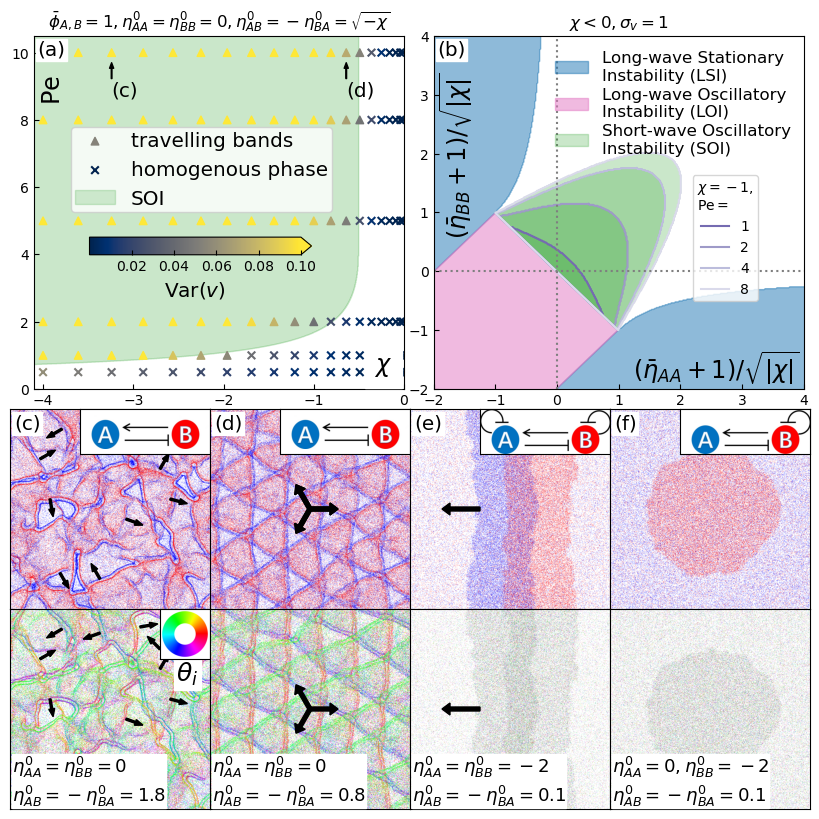

In [14]:
fig